This notebook compares the performance of different distributed estimation schemes :<br>
- KCF (Kalman Consensus Filter, 2007)<br>
- OKCF (Optimal KCF, 2017) <br>
- KCF-WDG (KCF with Weighted Consensus, 2019)<br>

In [1]:
import os
import settings.input
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 500

# Choose target and sensor-network
input_files = []
input_files.append(os.path.join("settings","json_files", "target-rotating.json"))
input_files.append(os.path.join("settings","json_files", "graph-chain.json"))

# Read input files
input_data = settings.input.read(input_files)

Consider a network of sensors connected as,

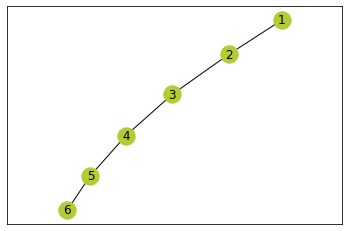

In [2]:
from sim.helpers import graph_plot
graph_plot(input_data["network"]["adjacency"])

Consider the scenario where some sensors have high estimation error (essentially 'naive'). 

We expect this to cause relatively poor performance throughout the network, in the case of distributed estimation schemes that do not weight their neighbors' information (such as the Kalman Consensus Filter).

In the following simulation, the sensor network observes a target in a circular trajectory (in presense of significant system noise). Sensors `4`, `5` and `6` are naive for a part of the simulation. <br>
We compare the performance of KCF, OKCF & KCF-WDG :

In [3]:
from sim.simulation import Simulation
import numpy as np
from sim.helpers import column

initial_estimate = column([[0], [0]])
initial_ErrCov = 100*np.identity(2)
initial_NoiseCov = 100*np.identity(2)
naive_NoiseCov = 100000*np.identity(2)

simulation = Simulation(input_data, est_schemes=["KCF", "OKCF", "KCF-WDG"], duration = 20)

# Initial values
simulation.add_sensor_event(iteration=0, attribute="estimate_prior", value=initial_estimate)
simulation.add_sensor_event(iteration=0, attribute="ErrCov_prior", value=initial_ErrCov)

# Sensor 4, 5 & 6 become naive from iter. 20-40
simulation.add_sensor_event(iteration=0, attribute="NoiseCov", value=initial_NoiseCov)
simulation.add_sensor_event(iteration=20, sensors=["4", "5", "6"], attribute="NoiseCov", value=naive_NoiseCov)
simulation.add_sensor_event(iteration=40, sensors=["4", "5", "6"], attribute="NoiseCov", value=initial_NoiseCov)

# Averaged over 'n_simulations' simulations
simulation.run(n_simulations=1)

  0%|          | 0/1 [00:00<?, ?it/s]

Selected scheme KCF
Selected scheme Optimal KCF (It's not fully-distributed!)
Selected scheme OKCF-WDG (It's not fully-distributed!)




100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


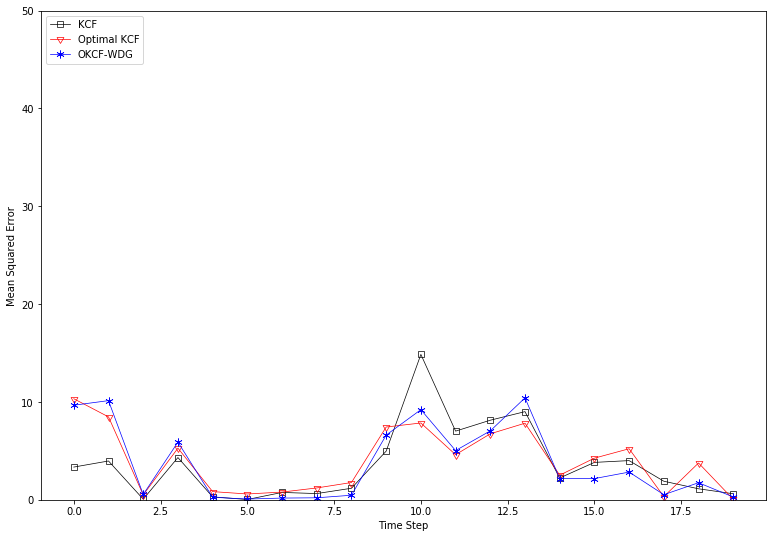

In [4]:
# simulation.plot_xy(sensor="3")
simulation.plot_error_squared(sensor="4", ylim=50.0)
#simulation.plot_xy(sensor="3")

Evidently, the error of KCF and OKCF climbs during the 'naive' period. KCF-WDG has a small bounded increase in error.<br>

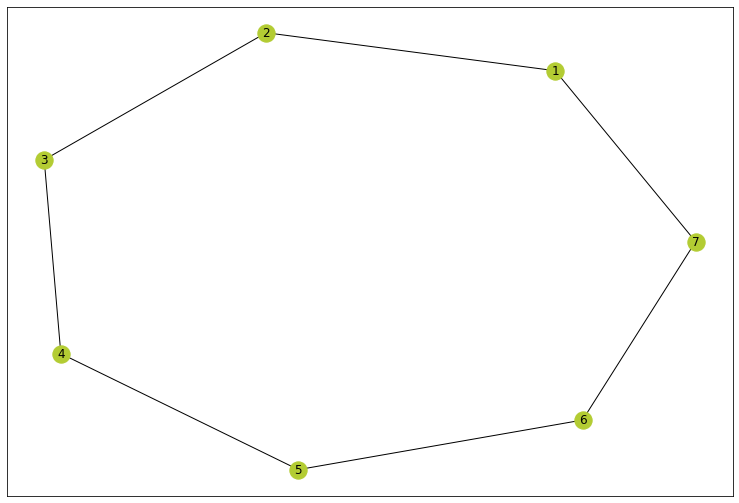

In [5]:
import os
import settings.input

input_files = []
input_files.append(os.path.join("settings","json_files", "target-4D.json"))
input_files.append(os.path.join("settings","json_files", "graph-circle.json"))
input_data = settings.input.read(input_files)

from sim.helpers import graph_plot; graph_plot(input_data["network"]["adjacency"])

  0%|          | 0/20000 [00:00<?, ?it/s]

Selected scheme KCF
Selected scheme Optimal KCF (It's not fully-distributed!)
Selected scheme OKCF-WDG (It's not fully-distributed!)
Field-of-view will be checked during this simulation. Measurement noise covariance will be overwritten by simulation specifications.




100%|██████████| 20000/20000 [6:04:32<00:00,  1.09s/it]  



------------------------------------

Plot is being limited to 400 units in either axis.
Estimates of Sensor 6 using KCF : 


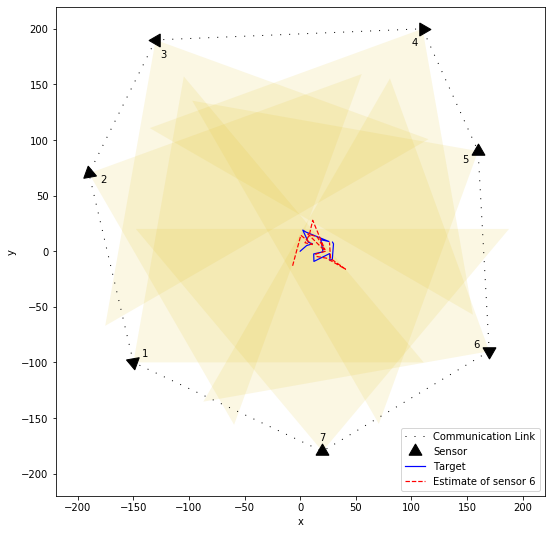

Plot is being limited to 400 units in either axis.
Estimates of Sensor 6 using OKCF : 


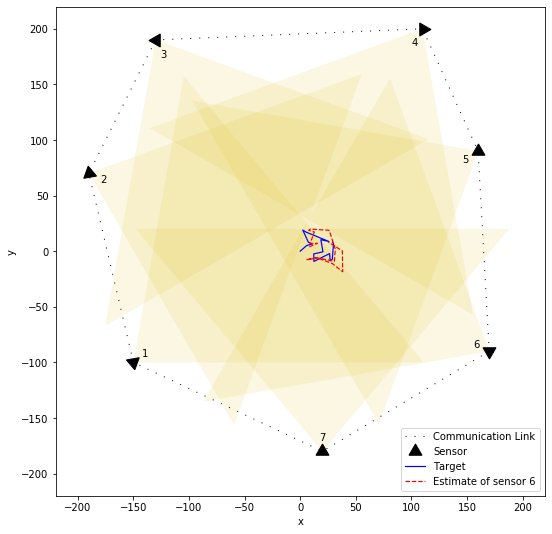

Plot is being limited to 400 units in either axis.
Estimates of Sensor 6 using KCF-WDG : 


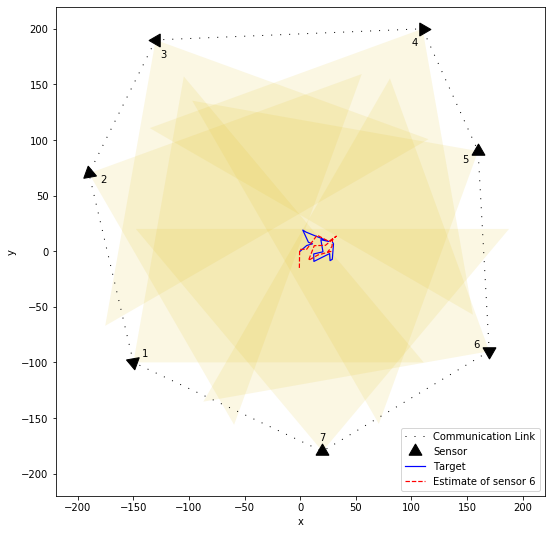

In [6]:
from sim.simulation import Simulation
import numpy as np
from sim.helpers import column

initial_target = column([[0], [0], [0], [0]])
initial_estimate = column([[10], [10], [-10], [10]]) # Earlier, 10 10 -10 10
initial_ErrCov = 1000*np.identity(4)
initial_NoiseCov = 100*np.identity(2)

simulation = Simulation(input_data, est_schemes=["KCF", "OKCF", "KCF-WDG"], duration = 16)

# Initial values
simulation.add_target_event(iteration=0, attribute="x", value=initial_target)
simulation.add_sensor_event(iteration=0, attribute="estimate_prior", value=initial_estimate)
simulation.add_sensor_event(iteration=0, attribute="ErrCov_prior", value=initial_ErrCov)
simulation.setup_fov_2D(positions=[[-150,-100],[-190,70],[-130,190],[110,200],[160,90],[170,-90],[20,-180]], 
                        angles=[40,-20,-60,-120,-150,150,90], fov_angle=80, fov_range=200)

# Averaged over 'n_simulations' simulations
simulation.run(n_simulations=20000)

simulation.plot_xy(sensor="6")

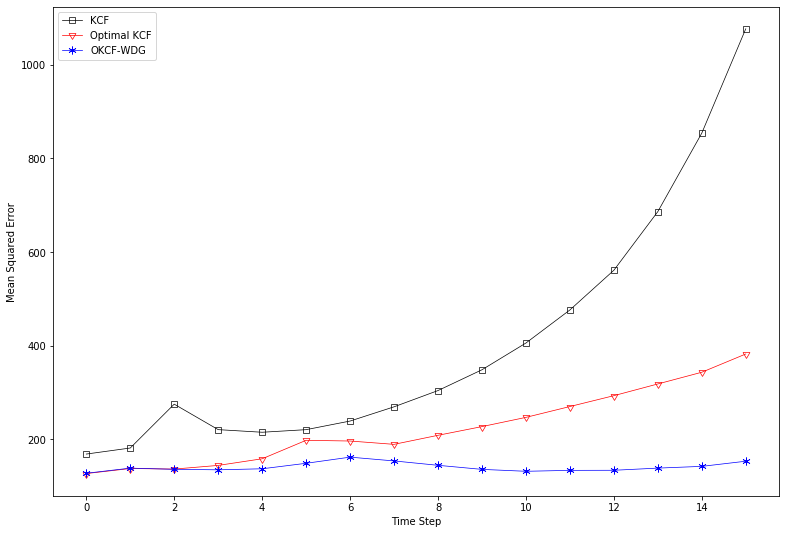

In [8]:
simulation.plot_error_squared("5")


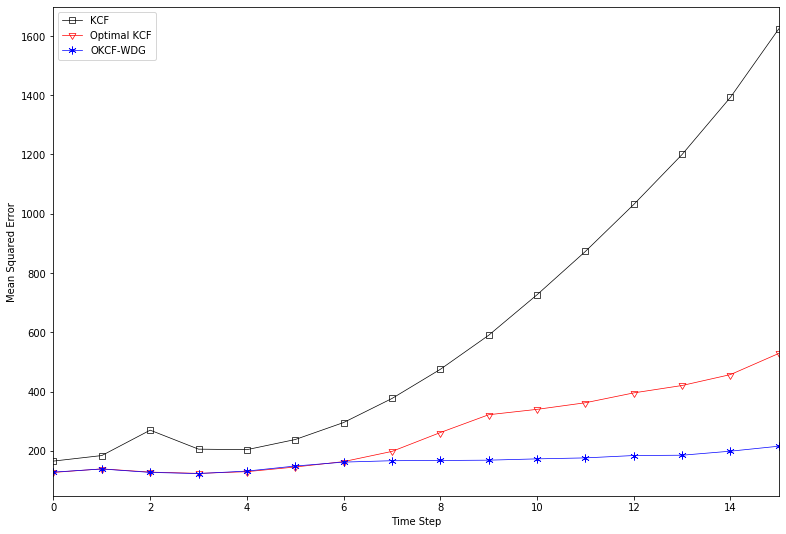

In [9]:
simulation.plot_error_squared("1", xlim=15)

In [30]:
# import matplotlib.pyplot as plt
# STYLES = ["sk-", "vr-", "*b-"]
# MARKER_STYLES = [(4, 0, 45), (3, 0, 180), (6, 2, 0)]
# MARKER_COLORS = ["black", "red", "blue"]

# def line_plot(y_values_list, x_values, title=None, ylabel=None, xlabel=None, labels=None, xlim=None, ylim=None,
#               legend_loc='lower right'):
#     """
#     :param y_values_list: list(list())
#     :param x_values: list()
#     :param title: str
#     :param ylabel: str
#     :param xlabel: str
#     :param labels: list(str)
#     :param ylim: float
#     """
#     plt.rcParams["figure.figsize"] = [9,6]
#     for i, y_values in enumerate(y_values_list):
#         plt.plot(x_values, y_values, marker=MARKER_STYLES[i], color=MARKER_COLORS[i], label=labels[i], fillstyle="none", markersize=8, markeredgewidth=0.7, lw=0.7)

#     plt.title(title) if title else None
#     plt.xlabel(xlabel) if xlabel else None
#     plt.ylabel(ylabel) if ylabel else None
#     plt.xlim(0, xlim) if xlim else None
#     plt.ylim(0, ylim) if ylim else None
#     plt.legend(loc=legend_loc)
#     plt.show()

# def plot_mse_sim(sim, sensor, xlim=None, ylim=None):
#         values = []
#         labels = []
#         for name, res in sim.results.items():
#             values.append(res["error_squared"][sensor])
#             labels.append(name)

#         line_plot(values, range(sim.duration),
#                   ylabel="Mean Squared Error", xlabel="Time Step",
#                   labels=labels,
#                   xlim=xlim,
#                   ylim=ylim,
#                   legend_loc='upper left')


In [6]:
#plot_mse_sim(simulation, "1", xlim=15, ylim=1800)


In [7]:
#plot_mse_sim(simulation, "5", xlim=15, ylim=1200)

In [8]:
#plot_mse_sim(simulation, "7", xlim=15, ylim=2200)